# Boston House Prices

In [266]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
%matplotlib inline

In [267]:
train = pd.read_csv('./train.csv')      #1460*81
test = pd.read_csv('./test.csv')        #1459*80
train.shape, test.shape

((1460, 81), (1459, 80))

In [268]:
#train["SalePrice"] = np.log1p(train["SalePrice"])

In [269]:
# Remove outliers
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)
train.shape, test.shape

((1457, 81), (1459, 80))

In [270]:
# Split features and labels
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2916, 80)

In [271]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [272]:
def handle_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

all_features = handle_missing(all_features)

In [273]:
# 범주형 데이터 추출
categorical_features = all_features.select_dtypes(include=['object'])

# 수치형 데이터 추출
numeric_features = all_features.select_dtypes(exclude=['object'])
categorical_features.shape , numeric_features.shape

((2916, 46), (2916, 34))

In [274]:
categorical_L = []
categorical_len = []

for col in categorical_features.columns:
    # One-Hot Encoding 수행
    # 값의 순서대로 0부터 새로운 값을 할당
    em , di = pd.factorize(categorical_features[col])
    categorical_L.append(em)
    categorical_len.append(len(di))

categorical_features_encoded = np.stack(categorical_L,1)
categorical_features_encoded.shape , numeric_features.shape

((2916, 46), (2916, 34))

In [275]:
categorical_features_size = []
for x in categorical_len:
    categorical_features_size.append((x,x//3+1))

In [276]:
all_features = np.concatenate([categorical_features_encoded,numeric_features],1)
X = all_features[:len(train_labels), :]
X_test = all_features[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1457, 80), (1457,), (1459, 80))

In [277]:
from sklearn.model_selection import train_test_split
X_train , X_val , y_train , y_val = train_test_split(X, train_labels.to_numpy(),test_size=0.2, shuffle=True,random_state=5252)

X_train , y_train = torch.tensor(X_train,dtype=torch.float32) , torch.tensor(y_train,dtype=torch.float32)
X_val , y_val = torch.tensor(X_val,dtype=torch.float32) , torch.tensor(y_val,dtype=torch.float32)
X_test= torch.tensor(X_test,dtype=torch.float32)
print(X_train.shape,y_train.shape)

# 데이터로더
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test,torch.zeros(X_test.shape[0])), batch_size=batch_size, shuffle=True)

torch.Size([1165, 80]) torch.Size([1165])


모델

In [282]:
class Model(nn.Module):
    def __init__(self, embedding_size, layers,layer_size=20, p=0.2,categorical_size=46,numeric_size=34):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.dropout = nn.Dropout(p)
        self.categorical_size = categorical_size
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        self.input_batch = nn.BatchNorm1d(numeric_size)

        all_layers = []
        input_size_t = num_categorical_cols+numeric_size
        for i in layers:
            all_layers.append(nn.Linear(input_size_t, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size_t = i
        all_layers.append(nn.Linear(layers[-1], layer_size))
        self.layers = nn.Sequential(*all_layers)
        self.outlayer = nn.Linear(layer_size, 1)

    def forward(self, x):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x[:,i].long()))
        x1 = torch.cat(embeddings, 1)
        x2 = self.input_batch(x[:,self.categorical_size:])
        x = torch.cat((x1,x2),1)
        x = self.dropout(x)
        x = self.layers(x)
        x = self.outlayer(x)
        return x

In [279]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [295]:
model = Model(categorical_features_size,[10*i for i in range(50,1,-5)], p=0.4)
model.to(device)
#print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, y_pred, y_true):
        mse_loss = nn.MSELoss()
        rmse_loss = torch.sqrt(mse_loss(torch.log(y_pred), torch.log(y_true)))
        return rmse_loss
RMSEloss = RMSELoss()

In [296]:
Epoch = 100
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, 
                                                steps_per_epoch=len(train_loader), epochs=Epoch,anneal_strategy='cos',pct_start=0.2)
train_rmseloss , valid_rmseloss = [] , []           # rmse를 추적

for epoch in range(1,Epoch+1):
    total_rmseloss , total_count = 0 , 0 
    model.train()
    for data, y in train_loader:
        data , y = data.to(device) , y.to(device)
        output = model(data)
        rmseloss = RMSEloss(output, y)
        optimizer.zero_grad()
        rmseloss.backward()
        optimizer.step()
        scheduler.step()

        count = torch.sum(output < y)
        total_rmseloss += len(data)*rmseloss.item()
        total_count += count.item()

    total_rmseloss /= len(train_loader.dataset)
    total_count /= len(train_loader.dataset)

    train_rmseloss.append(total_rmseloss)
    print(f'Epoch{epoch} train_loss:{total_rmseloss:.2f} ',end='  ')

    total_rmseloss , total_count = 0 , 0 
    model.eval()
    with torch.no_grad():
        for data, y in valid_loader:
            data , y = data.to(device) , y.to(device)
            output = model(data)
            rmseloss = RMSEloss(output, y)

            count = torch.sum(output < y)
            total_rmseloss += len(data)*rmseloss.item()
            total_count += count.item()

        total_rmseloss /= len(valid_loader.dataset)
        total_count /= len(valid_loader.dataset)

        valid_rmseloss.append(total_rmseloss)
        print(f'valid_loss:{total_rmseloss:.2f}')
    torch.save(model.state_dict(), os.path.join('./model_data/', '{0:0=2d}.pth'.format(epoch)))

Epoch1 train_loss:nan   valid_loss:nan
Epoch2 train_loss:nan   valid_loss:nan
Epoch3 train_loss:nan   valid_loss:nan
Epoch4 train_loss:nan   valid_loss:nan
Epoch5 train_loss:nan   valid_loss:nan
Epoch6 train_loss:nan   valid_loss:nan
Epoch7 train_loss:nan   valid_loss:nan
Epoch8 train_loss:nan   valid_loss:nan
Epoch9 train_loss:nan   valid_loss:nan
Epoch10 train_loss:nan   valid_loss:nan
Epoch11 train_loss:nan   valid_loss:nan
Epoch12 train_loss:nan   valid_loss:nan
Epoch13 train_loss:nan   valid_loss:nan
Epoch14 train_loss:nan   valid_loss:nan
Epoch15 train_loss:nan   valid_loss:nan
Epoch16 train_loss:nan   valid_loss:nan
Epoch17 train_loss:nan   valid_loss:nan
Epoch18 train_loss:nan   valid_loss:nan
Epoch19 train_loss:nan   valid_loss:nan
Epoch20 train_loss:nan   valid_loss:nan
Epoch21 train_loss:nan   valid_loss:nan
Epoch22 train_loss:nan   valid_loss:nan
Epoch23 train_loss:nan   valid_loss:nan
Epoch24 train_loss:nan   valid_loss:nan
Epoch25 train_loss:nan   valid_loss:nan
Epoch26 t

KeyboardInterrupt: 

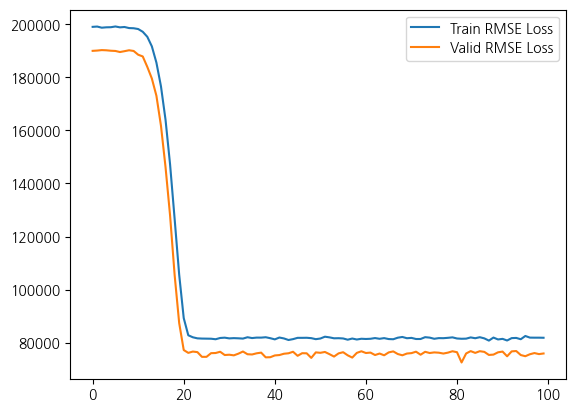

In [ ]:
sns.lineplot(train_rmseloss, label='Train RMSE Loss')
sns.lineplot(valid_rmseloss, label='Valid RMSE Loss')
plt.legend()
plt.show()

In [ ]:
# test
best_epoch = np.argmin(np.array(valid_rmseloss)) + 1
print(f'최적의 epoch는 {best_epoch}')
model.load_state_dict(torch.load(os.path.join('./model_data/', '{0:0=2d}.pth'.format(best_epoch))))
model.eval()

answer = []
with torch.no_grad():
    for data , y in test_loader:
        data = data.to(device)
        output = model(data)
        answer.append(output)

최적의 epoch는 82


In [ ]:
concatenated_tensor = torch.cat(answer, dim=0)
flattened_tensor = torch.flatten(concatenated_tensor)
answer_array = flattened_tensor.cpu().numpy()

In [ ]:
#answer_array = np.expm1(answer_array)

In [ ]:
sub = pd.read_csv('./sample_submission.csv')
sub['SalePrice'] = answer_array

In [290]:
sub.to_csv('answer6.csv', index=False)